# Churn Analysis for Sparkify
# Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul><li><a href="#gather">Gather data</a></li></ul>
    <ul><li><a href="#assess_and_clean">Assess and clean</a></li></ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
# Intro
We're analyzing data of a music streaming service named Sparkify. The goal is the prediction of customer turnover (churn). The full dataset is 12 GB of logfile data. Apache Spark as a technology for distributed data processing is used to cope with this amount of data. This workspace uses a 0.1 GB subset of the data.

<a id='wrangling'></a>
# Data Wrangling
<a id='gather'></a>
## Gather data
Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import datetime
import time

from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from pyspark.sql.functions import count, when, isnan, col, desc, udf, avg, row_number, datediff, lit
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from sqlalchemy import create_engine

Create a Spark session:

In [2]:
spark = SparkSession.builder \
    .appName('Sparkify') \
    .getOrCreate()

In [3]:
sparkify = 'mini_sparkify_event_data.json'
# path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(sparkify)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

<a id='assess_and_clean'></a>
## Assess and clean

In [4]:
print('The dataset has {} rows and {} users.'.format(df.count(), df.select('userId').drop_duplicates().count()))

The dataset has 286500 rows and 226 users.


In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# profit from both techniques: 
# aggregate with Spark and present the output using the Pandas dataframe formatting
pd.DataFrame(df.head(1), columns=df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
# lines per user
df.groupby('userId').count().orderBy(desc('count')).show(5)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
+------+-----+
only showing top 5 rows



Summary statistics: learn about the data and find unexpected entries:

In [8]:
df.describe(df.columns[:6]).show()

+-------+------------------+----------+---------+------+------------------+--------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|
+-------+------------------+----------+---------+------+------------------+--------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|
+-------+------------------+----------+---------+------+------------------+--------+



In [9]:
df.describe(df.columns[7:13]).show()

+-------+------+-----------------+------+-------+--------------------+-----------------+
|summary| level|         location|method|   page|        registration|        sessionId|
+-------+------+-----------------+------+-------+--------------------+-----------------+
|  count|286500|           278154|286500| 286500|              278154|           286500|
|   mean|  null|             null|  null|   null|1.535358834084427...|1041.526554973822|
| stddev|  null|             null|  null|   null| 3.291321616327586E9|726.7762634630741|
|    min|  free|       Albany, OR|   GET|  About|       1521380675000|                1|
|    max|  paid|Winston-Salem, NC|   PUT|Upgrade|       1543247354000|             2474|
+-------+------+-----------------+------+-------+--------------------+-----------------+



In [10]:
df.describe(df.columns[14:]).show()

+-------+------------------+--------------------+--------------------+-----------------+
|summary|            status|                  ts|           userAgent|           userId|
+-------+------------------+--------------------+--------------------+-----------------+
|  count|            286500|              286500|              278154|           286500|
|   mean|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+------------------+--------------------+--------------------+-----------------+



### Invalid/missing data
#### userID and sessionID: We find no NaN or Null values  ...

In [11]:
# inspired by https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe/44631639#44631639
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

#### ... but some empty strings in userID
The function 'describe' above shows there is no empty string in `sessionId` but at least one empty string in `userId` (min() is an empty string).

We notice that for empty `userId`s the auth shows 'Logged Out'...

In [12]:
print('UserId is empty in {} cases.'.format(df.filter(df.userId == '').count()))
df.filter(df.userId == '').groupBy('auth').count()

UserId is empty in 8346 cases.


DataFrame[auth: string, count: bigint]

... and we find that __the userId is missing _only_ when the user is not logged in__:

In [13]:
df.filter((df.userId == '') & (df.auth != 'Logged In')).count()

8346

#### Remove lines w/o userId
__Define:__<br>
filter using `userId != ''`.

__Code:__

In [14]:
lines_0 = df.count()
df = df.filter(df.userId != '')

__Test:__

In [15]:
df.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



In [16]:
print('{:.0%} (count: {}) of the dataset rows are left.'.format(df.count() / lines_0, df.count()))

97% (count: 278154) of the dataset rows are left.


### NaN in other columns
NaN check above reveals: song, length, artist are missing the same number of rows & are missing more rows than the userId.

In [17]:
print("{} lines are completely filled and there are {} lines where the 'page' is 'NextSong'.".format(
    df.dropna(how='any').count(),
    df.filter(~df.song.isNull()).groupBy('page').count().sort(desc('count')).select('count').collect()))

print('\n{:.0%} of the log entries are songs requested.'.format(df.dropna(how='any').count() / df.count()))

228108 lines are completely filled and there are [Row(count=228108)] lines where the 'page' is 'NextSong'.

82% of the log entries are songs requested.


The columns song, length, artist are filled when the Sparkify user listens to songs. They are not filled e.g. for log entries "Add to Playlist", "Thumbs Up", etc.

$\rightarrow$ no problems to tackle with NaN values in other columns

<a id='eda'></a>
# Exploratory Data Analysis and Feature Engineering
Creating per user:
- the Churn label, _and the features:_
- Days with a listening activity
- Songs per Day
- Account age
- Gender

This is a concise set of possibly relevant features. The activity per day seems to be a reasonable approach. A possible extension is to check the impact of features with lower or higher frequency.

Those with the most rows when logged in are candidates for the heaviest users:

In [18]:
df.groupBy('userId').count().sort(desc('count')).show(3)

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
+------+-----+
only showing top 3 rows



### Define Churn
#### Check how to identify churn
We identify churn as cancelling the usage. This is possible for both paid and free users and thus allows to train the model for both groups.

In [19]:
# which page values exist? (not printed for brevity)
#df.select('page').dropDuplicates().sort('page').show() 

cancel_event_count = df.where(df.page == 'Cancellation Confirmation').count()
account_count = df.select('userId').drop_duplicates().count()
print('There are {} cancellation events for {} accounts in the dataset (i.e. {:.0%} churn).'.format( 
    cancel_event_count, account_count, cancel_event_count / account_count))

There are 52 cancellation events for 225 accounts in the dataset (i.e. 23% churn).


$\rightarrow$ adequate churn share in data to train a model

### Create churn column
__Define:__<br> 
Identify Churn as `df.page == 'Cancellation Confirmation'`. Create a column `Churn_user` which is 1 for a user with a cancellation confirmation. The cancellation is possible for both paid and free users.

__Code:__

In [20]:
# create flag churn
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

# create churn column: mark event
df = df.withColumn('Churn', churn_event(df.page))

# create churn column: mark customer (=userId); heavy lifting by Spark, list of userIds easier with Pandas
users_churn = df.where(df.Churn == 1).select('userId').drop_duplicates().toPandas().values.tolist()
users_churn = list(np.concatenate(users_churn).flat)  
df = df.withColumn('Churn_user', when(col('userId').isin(users_churn), 1).otherwise(0))
print('{} users churned'.format(df.select('userId').filter(df.userId.isin(users_churn)).dropDuplicates().count()))

52 users churned


#### Test:
column 'Churn' is 1 only in in cancellation row:

In [21]:
df.select(['userId', 'firstName', 'ts', 'page', 'level', 'Churn']).where(df.userId == '125').sort('ts').collect()

[Row(userId='125', firstName='Mason', ts=1539317144000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317481000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317711000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539317914000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318124000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318515000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318728000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318906000, page='NextSong', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318917000, page='Roll Advert', level='free', Churn=0),
 Row(userId='125', firstName='Mason', ts=1539318918000, page='Cancel', level='free', Churn=0),
 Row(userId='125', firstName=

Plot the churn user share:

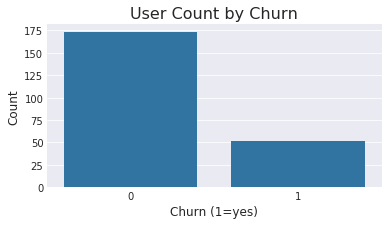

In [22]:
df_churn_pd = df.select(['userId', 'Churn_user']).drop_duplicates().groupBy('Churn_user').count().toPandas()

base_color = sb.color_palette()[0]
plt.figure(figsize = (6, 3))
sb.set_style('darkgrid')
sb.barplot(y='count', x='Churn_user', data=df_churn_pd, color=base_color)
plt.title('User Count by Churn', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('Count', fontsize=12);

### Feature: Songs per User

#### Songs per User as first impression, used as feature only after time scaling (per day) performed below
Those who cancel the service did use it considerably on average.

In [24]:
songs_by_churn = df.filter(df.page == 'NextSong').groupby(df.Churn_user).count().orderBy(df.Churn_user).toPandas()['count']
count_by_churn = df.groupBy('Churn').count().orderBy('Churn').toPandas()['count']
print('Songs by churn:\n', songs_by_churn, 
      '\n\nSongs per User by Churn:\n', songs_by_churn / count_by_churn)

Songs by churn:
 0    191714
1     36394
Name: count, dtype: int64 

Songs per User by Churn:
 0      0.689366
1    699.884615
Name: count, dtype: float64


In [25]:
# skipped for brevity:
## Most heavy users of those who cancel: e.g. user 29
# df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy(desc('count')).show(1)
## Least heavy users of those who cancel: e.g. user 125
# df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().orderBy('count').show(1)

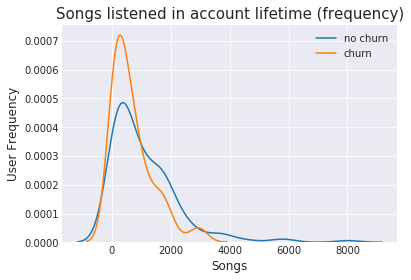

In [26]:
# plot distribution of songs per user listened (no time scaling)
df_pd_0 = df.filter((df.page == 'NextSong') & (df.Churn_user == 0)).groupby('userId').count().toPandas()
df_pd_1 = df.filter((df.page == 'NextSong') & (df.Churn_user == 1)).groupby('userId').count().toPandas()

sb.distplot(df_pd_0['count'], hist=False, label='no churn')
sb.distplot(df_pd_1['count'], hist=False, label='churn')
plt.legend()
plt.title('Songs listened in account lifetime (frequency)', fontsize=15)
plt.xlabel('Songs', fontsize=12)
plt.ylabel('User Frequency', fontsize=12);

__Interpreting__ the figure:

$\rightarrow$ Those who cancel typically listen to less songs in their lifetime. $\rightarrow$ check below for the activity per time unit.

### Feature: Days listened & Songs per Day

__Define:__
aggregate to 1 row per userID to generate usual input for a non-time-series model instead of multiple lines per user

Days listened = count the days where a user listened to songs

The average of days where the user listened would be inappropriate (e.g. only listening on the 30th of a month would be a higher value than listening every day

#### how many songs does the user listen to?
The song count per userId might be too skewed for users new to the service vs. not new

Therefore: average songs listened to on days where the service is used

__Code:__

In [27]:
# create column day of month (integer)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df = df.withColumn('day', get_day(df.ts))

# songs per user and day of month
songs_in_day = df.filter(df.page == 'NextSong').groupby([df.userId, df.day]) \
                .count().orderBy(df.userId, df.day.cast('float'))

# aggregate to days where the user listened to songs + renaming column
songs_user = songs_in_day.groupby(['userId']).agg(count(col('day')), 
                                                  avg(col('count'))).orderBy('userId')
songs_user = songs_user.select(col('userId'), 
                               col('count(day)').alias('days_listened'), 
                               col('avg(count)').alias('songs_per_day'))

__Test:__

In [28]:
songs_user.show(3)

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    10|            7|96.14285714285714|
|   100|           25|           107.28|
|100001|            2|             66.5|
+------+-------------+-----------------+
only showing top 3 rows



In [29]:
# cross-check with separately doing a single aggreagation -> fine
songs_user_test = songs_in_day.groupby(['userId']).agg(avg(col('count'))).orderBy('userId')
#songs_user = songs_user.select(col('userId'), col('count(day)').alias('days_listened'))
songs_user_test.first()

Row(userId='10', avg(count)=96.14285714285714)

In [30]:
# cross-check for a heavy user identified above listening to a lot of songs
songs_user.where(songs_user.userId == 39).show() # listens on all days

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    39|           31|258.1290322580645|
+------+-------------+-----------------+



### Feature: Account age
How long is the customer using the service already? Idea: Who did not churn for a while is less likely to churn in the next time period.

In [31]:
# registration date is given in all data rows for a customer
print('all users have just 1 registration date:', 
      df.select('userId', 'registration').dropDuplicates().count() == df.select('userId').dropDuplicates().count())

all users have just 1 registration date: True


In [32]:
# taking one value from 'registration' column to figure out how to cast to date
spark.sql("select to_date(to_timestamp(1538352117000/1000))").show()

+------------------------------------------------------------------------------+
|to_date(to_timestamp((CAST(1538352117000L AS DOUBLE) / CAST(1000 AS DOUBLE))))|
+------------------------------------------------------------------------------+
|                                                                    2018-10-01|
+------------------------------------------------------------------------------+



#### Define
The account age is the time the customer is using the service. It's the time between the registration and the dataset date, e.g. the newest date included in the dataset. For customers who churned it ends with the churn event.

1. Extract the date (column name: `date`) from the timestamp `df.ts` and the registration date from `df.registration` (column name: `date_reg`). Use the maximum of the timestamp date as `dataset_date`. 
2. Sort by user and timestamp. Get the last row which contains the churn date in the `date` column. For non-churn users, the columns `dataset_date` and `date_reg` are relevant which are the same in all rows for a user.
3. Get the date difference in days between the churn date and `date_reg` for churn users, and between `dataset_date` and `date_reg` respectively.

#### Code

In [33]:
## 1.
# timestamp as date: 
df = df.withColumn('date', F.to_date(F.to_timestamp(df.ts/1000)))
# registration date:
df = df.withColumn('date_reg', F.to_date(F.to_timestamp(df.registration/1000)))
# dataset date: use the overall maximum timestamp
df = df.withColumn('dataset_date', lit(df.agg(F.max(col('date'))).collect().pop()[0])) # 03.12.2018

## 2. get last row:
# inspired by https://stackoverflow.com/questions/40889564/pyspark-groupby-and-max-value-selection#40892037
w = Window().partitionBy('userId').orderBy(F.desc('ts'))
df_age = df.withColumn('rank', F.dense_rank().over(w))
df_age = df_age.where(F.col('rank')==1)

## 3. date difference
df_age = df_age.withColumn('account_age', 
    when(df_age.userId.isin(users_churn), datediff(df_age.date, df_age.date_reg))
    .otherwise(datediff(df_age.dataset_date, df_age.date_reg)))
df_age = df_age.select('userId', 'account_age')

#### Test

In [34]:
# selecting the last row per user with Pandas 
df.select('userId', 'Churn_user', 'date', 'date_reg', 'dataset_date').orderBy('userId').toPandas().groupby('userId').tail(1).head(3)

,userId,Churn_user,date,date_reg,dataset_date
794,10,0,2018-11-19,2018-09-28,2018-12-03
4008,100,0,2018-11-30,2018-09-26,2018-12-03
4195,100001,1,2018-10-02,2018-08-18,2018-12-03


In [35]:
df_age.orderBy('userId').show(3)

+------+-----------+
|userId|account_age|
+------+-----------+
|    10|         66|
|   100|         68|
|100001|         45|
+------+-----------+
only showing top 3 rows



In [36]:
# check ok:
## non-churn user with 152 days
#df_age.where(col('userId')==67).toPandas()
## OK checking in raw data: reg_date 2018-07-04 to dataset_date 2018-12-03
## 152 days based on https://www.timeanddate.com/date/durationresult.html?d1=4&m1=7&y1=2018&d2=03&m2=12&y2=2018
#df.where(col('userId')==67).toPandas().tail(1)

# check ok:
## churn user with 20 days
#df_age.where(col('userId')==51).toPandas()
## OK checking in raw data: reg_date 2018-09-27 to cancel_date 2018-10-17
#df.where(col('userId')==51).toPandas().tail(1)

### combine data: label churn and static user features

#### Define:
The logfile stored in `df` has multiple rows per UserId. For any user, there are static columns, i.e. which always contain the same information. Examples are `gender` and whether the user churned, i.e. `Churn_user`.

Extract static features from `df`. Join it with the metrics calculated above, i.e. `songs_user` and `df_age`.

#### Code

In [37]:
# first row for each user
# inspired by https://sparkbyexamples.com/spark/spark-dataframe-how-to-select-the-first-row-of-each-group/
df_by_user = df.withColumn('row', row_number().over(Window.partitionBy('userId').orderBy('userId'))).where(col('row') == 1)

# reduce columns
df_by_user = df_by_user.select(['userId', 'Churn_user', 'gender'])

# join with songs_user
df_model = df_by_user.join(songs_user, on=['userId']).join(df_age, on=['userId']).orderBy('userId')

In [38]:
df_by_user.show(3)

+------+----------+------+
|userId|Churn_user|gender|
+------+----------+------+
|100010|         0|     F|
|200002|         0|     M|
|   125|         1|     M|
+------+----------+------+
only showing top 3 rows



In [39]:
songs_user.show(3)

+------+-------------+-----------------+
|userId|days_listened|    songs_per_day|
+------+-------------+-----------------+
|    10|            7|96.14285714285714|
|   100|           25|           107.28|
|100001|            2|             66.5|
+------+-------------+-----------------+
only showing top 3 rows



#### Test

In [40]:
print('1 row per unique userId:', 
      df_by_user.count() == df.select('userId').drop_duplicates().count())

1 row per unique userId: True


In [41]:
df_model_pd = df_model.toPandas()
df_model.show(3)

+------+----------+------+-------------+-----------------+-----------+
|userId|Churn_user|gender|days_listened|    songs_per_day|account_age|
+------+----------+------+-------------+-----------------+-----------+
|    10|         0|     M|            7|96.14285714285714|         66|
|   100|         0|     M|           25|           107.28|         68|
|100001|         1|     F|            2|             66.5|         45|
+------+----------+------+-------------+-----------------+-----------+
only showing top 3 rows



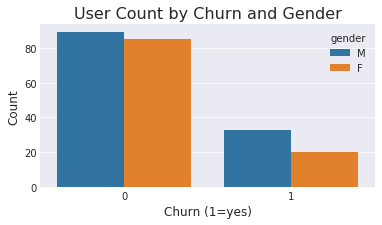

In [42]:
plt.figure(figsize = (6, 3))
sb.countplot(x='Churn_user', hue='gender', data=df_model_pd)
plt.title('User Count by Churn and Gender', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('Count', fontsize=12);

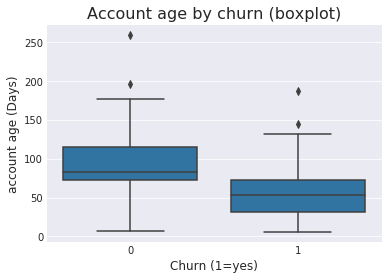

In [43]:
plt.figure(figsize = (6, 4))
sb.boxplot(data=df_model_pd, y='account_age', x='Churn_user', color=base_color)
plt.title('Account age by churn (boxplot)', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('account age (Days)', fontsize=12);

In [44]:
#import pandas as pd
#pd.read_csv('sparkify.csv')

#### who Churn listens on less days and less songs per day
Statement holds on average and looking at the distribution; the distribution for engangement is more clearly unimodal than for songs listened per day

In [45]:
df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').show()

+----------+------------------+
|Churn_user|avg(days_listened)|
+----------+------------------+
|         0|12.137931034482758|
|         1|  8.69811320754717|
+----------+------------------+



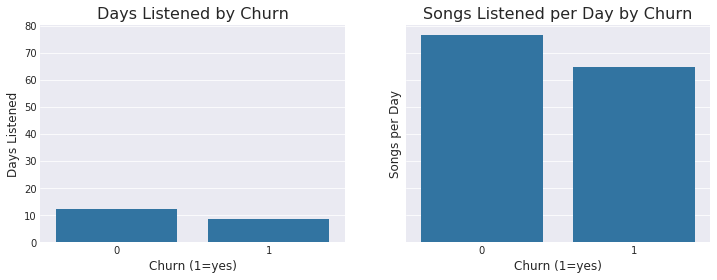

In [46]:
df_model_pd1 = df_model.groupby('Churn_user').agg(avg(col('days_listened'))).orderBy('Churn_user').toPandas()
df_model_pd2 = df_model.groupby('Churn_user').agg(avg(col('songs_per_day'))).orderBy('Churn_user').toPandas()

# subplotting inspired by https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharey=True)

sb.barplot(ax=ax[0], x='Churn_user', y='avg(days_listened)', data=df_model_pd1, color=base_color)
ax[0].set_title('Days Listened by Churn', fontsize=16)
ax[0].set_xlabel('Churn (1=yes)', fontsize=12)
ax[0].set_ylabel('Days Listened', fontsize=12);

sb.barplot(ax=ax[1], x='Churn_user', y='avg(songs_per_day)', data=df_model_pd2, color=base_color)
ax[1].set_title('Songs Listened per Day by Churn', fontsize=16)
ax[1].set_xlabel('Churn (1=yes)', fontsize=12)
ax[1].set_ylabel('Songs per Day', fontsize=12);

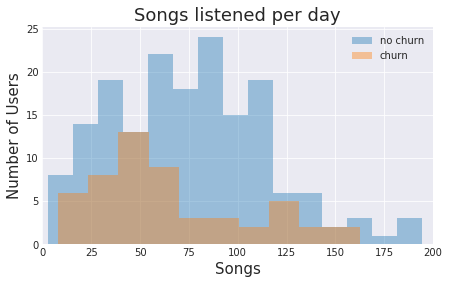

In [47]:
# plot distribution of songs per user & day listened
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('songs_per_day').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('songs_per_day').toPandas()

## as histogram:
#sb.distplot(df_pd_0.songs_per_day, hist=False, label='no churn')
#sb.distplot(df_pd_1.songs_per_day, hist=False, label='churn')
#plt.legend()
#plt.title('Songs Listened per day (frequency)')
#plt.xlabel('Songs')
#plt.ylabel('User Frequency');

fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)
df_pd_0.songs_per_day.plot(kind='hist', bins=20, alpha=.4, label='no churn', xlim=(0,200))
df_pd_1.songs_per_day.plot(kind='hist', bins=10, alpha=.4, label='churn')

plt.title('Songs listened per day', fontsize=18)
ax.set_xlabel('Songs', fontsize=15)
ax.set_ylabel('Number of Users', fontsize=15)
ax.legend();

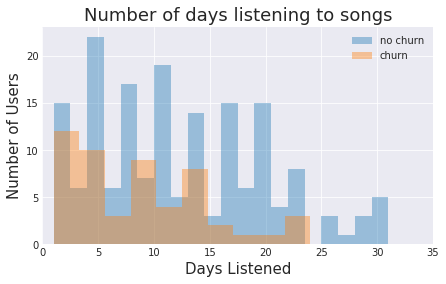

In [48]:
df_pd_0 = df_model.filter(df_model.Churn_user == 0).select('days_listened').toPandas()
df_pd_1 = df_model.filter(df_model.Churn_user == 1).select('days_listened').toPandas()

## as histogram:
#sb.distplot(df_pd_0.days_listened, hist=False, label='no churn')
#sb.distplot(df_pd_1.days_listened, hist=False, label='churn')
#plt.legend()
#plt.title('Engagement: number of days listening to songs (frequency)')
#plt.xlabel('Days Listened')
#plt.ylabel('User Frequency');

fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)
df_pd_0.days_listened.plot(kind='hist', bins=20, alpha=.4, label='no churn', xlim=(0,35))
df_pd_1.days_listened.plot(kind='hist', bins=10, alpha=.4, label='churn')

plt.title('Number of days listening to songs', fontsize=18)
ax.set_xlabel('Days Listened', fontsize=15)
ax.set_ylabel('Number of Users', fontsize=15)
ax.legend();

In [49]:
## optional: output the cleaned and feature-enriched model input to csv 
#print('model shape:', df_model_pd.shape)
#df_model_pd.to_csv('sparkify.csv', index=False)

In [50]:
## possible extension:
## create flag downgrade
#flag_downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())
#
### create downgraded column
#user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))
#user_log_valid.head()
#
### create flag free or paid phase
#windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0) # thinkof partition as groupBy; look at all preceeding rows but no following rows
#user_log_valid = user_log_valid.withColumn('phase', F.sum('downgraded').over(windowval))
#user_log_valid.select(['userId', 'firstName', 'ts', 'page', 'level', 'phase']).where(user_log.userId == '1138').sort('ts').collect()

# Modeling
We have a rather balanced dataset with an imbalance ratio of 4 (225 users in the small dataset / 52 users with a cancellation). This is due to the aggregation to the user level before the model training. Anyhow, an approach to control recall and precision has no relevant downsides:

We could favour recall or precision using an F-beta scorer with $\beta \ne 1$. We opt here to use the same weight optimizing the __F1-score__.

A baseline estimation predicting the majority class _no churn_ yields an F1-score of 67% (77% accuracy) using the small 225 customer dataset. Random Forest performs better than Logistic Regression in the test set and yields an improved F1-score of 93% (93% accuracy, 75% precision).

We split into train, test, and validation.

Deciding on the best approach: choose approach 2
1. two-step optimization: a) obtain performance metrics for different estimators, choose the best, b) search the optimal parameter for the model from (a) with a grid or randomized search cross-validation
2. one-step optimization: try different estimators based on parameter optimization for all of the models

$\rightarrow$ Approach (1) __might not identify the best model__ as a higher performance boost from (1b) might yield the best model is one that was weaker at first.<br>
$\rightarrow$ Approach (2) is used.

We simultaneously __optimize the algorithm and its parameters__. We obtain the same optimal algorithm (Random Forest) in the test set. Here shorter runtime is favoured over an exhaustive parameter set where the chances for improvement would increase.

In the __validation__ set the performance is not much worse with an F1-score of 87% (-6%), accuracy 88% (-5%), and precision 56% (-19%).

Note that the train-test split and cross-validation bring randomness to the results; we might add a random state to prevent the randomness.

More data = better results: Results considered _bad_ using a small dataset do not mean no hope. More data is expected to be more helpful for better results than improvements in terms of parameter choice.

In [51]:
# rename target column
# using standards 'label' and 'features' as describedin docs: https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forests
df_model = df_model.withColumnRenamed('Churn_user', 'label')

# train-test split
train, non_train = df_model.randomSplit([.6, .4], seed=42)
test, validate = non_train.randomSplit([.5, .5], seed=42)
print('Precise split of all rows:', df_model.count() == train.count() + test.count() + validate.count())

# number of records
print('rows -- total: {}, train: {}, test: {}, and validation: {}'.format(
    df_model.count(), train.count(), test.count(), validate.count()))

# build pipeline: use pipeline to prevent leaking knowledge from validation/test set
indexer = StringIndexer(inputCol='gender', outputCol='d_female')
assembler = VectorAssembler(inputCols=['days_listened', 'songs_per_day', 'account_age', 'd_female'], outputCol='features_unscaled')
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', withMean=True)
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
rf = RandomForestClassifier(seed=42)
estimator_list = [lr, rf]

Precise split of all rows: True
rows -- total: 227, train: 144, test: 15, and validation: 68


In [52]:
def evaluate_model(evaluator, result):
    ''' Evaluates the cross validation results.
    
    Input:
    evaluator -- instantiated evaluator object, e.g. MulticlassClassificationEvaluator()
    result -- cross-validation fit-transformed data
    
    Output:
    prints performance metrics f1, accuracy, and precision
    '''
    
    print('f1: {}'.format(round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)))
    # accuracy and precision
    correct_prediction_count, rows_all = result.filter(result.label == result.prediction).count(), result.count()
    precision_count, rows_precision = result.filter((result.label == 1) & (result.prediction == 1)).count(), result.filter(result.label == 1).count()
    print('accuracy: {:.0%} ({}/{}), and precision: {:.0%} ({}/{})'.format(
        correct_prediction_count / rows_all, correct_prediction_count, rows_all,
        precision_count / rows_precision, precision_count, rows_precision))
    print('... ran {} min.\n'.format(round((time.time() - start) / 60, 1)))

In [53]:
df_model.show(1)

+------+-----+------+-------------+-----------------+-----------+
|userId|label|gender|days_listened|    songs_per_day|account_age|
+------+-----+------+-------------+-----------------+-----------+
|    10|    0|     M|            7|96.14285714285714|         66|
+------+-----+------+-------------+-----------------+-----------+
only showing top 1 row



Baseline accuracy: always predict the majority class no-churn: 

In [54]:
df_model_naive = df_model.withColumn('prediction', lit(0).cast(DoubleType()))
start = time.time()
evaluator = MulticlassClassificationEvaluator()
evaluate_model(evaluator, df_model_naive)

f1: 0.67
accuracy: 77% (174/227), and precision: 0% (0/53)
... ran 1.1 min.



## baseline approach: multiple estimators, just one parameter choice

In [55]:
counter = 1
for estimator in estimator_list:
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    start = time.time()
    model = pipeline.fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    # f1 metric only available using the Spark MulticlassClassificationEvaluator, not so with the binary version https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.BinaryClassificationEvaluator.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator

    print('... ran {}min and yields:'.format(round((time.time() - start) / 60, 1)))
    print('f1: {}, and accuracy: {}'.format(
        round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2),
        round(evaluator.evaluate(result, {evaluator.metricName: 'accuracy'}), 2)))

1/2: LogisticRegression
... ran 1.7min and yields:
f1: 0.85, and accuracy: 0.87
2/2: RandomForestClassifier
... ran 1.7min and yields:
f1: 0.93, and accuracy: 0.93


## enhanced approach: multiple estimators, gridsearch over parameters simultaneously

Initiate and use a function to do not repeat yourself (DRY principle):

In [56]:
paramGrid_LogisticRegression = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1]) \
    .build()

# parameter options inspired by https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
paramGrid_RandomForestClassifier = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .build() #.addGrid(rf.maxDepth, [2, 10]): reducing runtime leaving alternative out
    # rf.criterion,['gini','entropy']
        
def create_cv(paramGrid, pipeline):
    return CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=2) # parallelism=2 # reducing runtime with folds unreasonably low < 3

## another option: randomized search -- cover a greater parameter range in the same time
# https://towardsdatascience.com/100x-faster-randomized-hyperparameter-searching-framework-with-pyspark-4de19e44f5e6
#num_trees =  random.choice(list(range(50,500)))
#depth = random.choice(list(range(2,10)))
#criterion = random.choice(['gini','entropy'])

Check multiple estimators as above, combine this with gridsearch:

In [57]:
counter = 1
best_f1 = 0

for estimator in estimator_list:
    print('{}/{}: {}'.format(counter, len(estimator_list), estimator.__class__.__name__))
    counter += 1
    pipeline = Pipeline(stages=[indexer, assembler, scaler, estimator])
    
    # create the CrossValidator object with the specific parameter grid and pipeline: 
    cv = create_cv(eval('paramGrid_' + estimator.__class__.__name__), pipeline)
    
    start = time.time()
    model = cv.fit(train)
    result = model.transform(test)
    evaluator = MulticlassClassificationEvaluator()
    f1 = round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)
    if f1 > best_f1:
        best_f1 = round(evaluator.evaluate(result, {evaluator.metricName: 'f1'}), 2)
        model_best = model.bestModel
    evaluate_model(evaluator, result)

1/2: LogisticRegression
f1: 0.85
accuracy: 87% (13/15), and precision: 50% (2/4)
... ran 6.1 min.

2/2: RandomForestClassifier
f1: 0.93
accuracy: 93% (14/15), and precision: 75% (3/4)
... ran 9.1 min.



Save model to disk $\rightarrow$ can use it without running the training job first

In [58]:
# see https://stackoverflow.com/questions/29255145/what-is-the-right-way-to-save-load-models-in-spark-pyspark?noredirect=1&lq=1
model_best.write().overwrite().save('pyspark_trained_model')

Load model from disk, check results in the __validation__ set:

In the validation vs. test set the performance is not much worse with an F1-score of 87% (-6%), accuracy 88% (-5%), and precision 61% (-14%). The small amount of data means higher result variation. Randomness comes from the train-test split and cross-validation.

In [59]:
# see https://stackoverflow.com/questions/52625639/unable-to-load-logistic-regression-model-in-spark-2-x
model_trained = PipelineModel.load('pyspark_trained_model')

# transform for validation set
# inspired by https://spark.apache.org/docs/latest/ml-pipeline.html#ml-persistence-saving-and-loading-pipelines
prediction = model_trained.transform(validate)
prediction = prediction.select(prediction.drop('features_unscaled', 'features', 'rawPrediction').columns)

# evaluate
evaluate_model(evaluator, prediction)

f1: 0.87
accuracy: 88% (60/68), and precision: 61% (11/18)
... ran 10.7 min.



### Predicting on new data
In a real-world application, we __should leave out the newest data, train a model on the remaining data and test with the newest data__. This can be extended by rolling the windows backwards.

Simplification used / out-of-scope of this project: Here we include all history for model training. This is a flawed approach, however sufficient for this toy example. Why flawed? We mislead the inference with the assumption all customers who did not churn yet will not churn. Example: A customer who churns the next day should be labelled as _churn_. To know the label we need to leave out the newest data for the features to produce accurate labels.

__Here we apply the best model found to the full dataset.__ This allows providing a churn probability for all customers in the Sparkify Callcenter Dashboard web app.

In [60]:
prediction_all = model_trained.transform(df_model)
prediction_all = prediction_all.select(prediction.drop('features_unscaled', 'features', 'rawPrediction').columns)
evaluate_model(evaluator, result=prediction_all)

f1: 0.91
accuracy: 92% (208/227), and precision: 70% (37/53)
... ran 12.2 min.



The standard 50% threshold is used to predict churn or no-churn based on the probability output of the model. We could easily extend the approach to set an individual threshold with a decision rule in the lambda function applied to the probability:

In [61]:
# create a Pandas DataFrame with the userId, features, and prediction:
sparkify = prediction_all.toPandas()
sparkify['probability'] = sparkify.probability.apply(lambda x: x[1])
sparkify['userId'] = sparkify.userId.apply(int)

# write to adatabase to be used as app input
engine = create_engine('sqlite:///sparkify.db')
sparkify.to_sql('user_table', engine, index=False, if_exists='replace')

print('Check database content... table exists and has entries:', 
      pd.read_sql('SELECT * FROM user_table', 
                  con=engine).shape[0] > 0)

Check database content... table exists and has entries: True


In [62]:
sparkify.head(3)

,userId,label,gender,days_listened,songs_per_day,account_age,d_female,probability,prediction
0,10,0,M,7,96.142857,66,0.0,0.051842,0.0
1,100,0,M,25,107.280000,68,0.0,0.053970,0.0
2,100001,1,F,2,66.500000,45,1.0,0.923046,1.0


Around 50% is a good candidate for the threshold to predict churn or no-churn. An aspect to investigate further is the true churn cases where the predicted probability is below 30%. The discussion of the approaches' flaws above ('Predicting on new data') might be the reason for this.

Correlation as a 1-figure impression of the model: 0.8


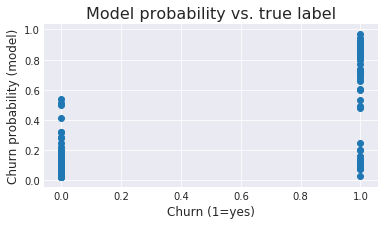

In [71]:
print('Correlation as a 1-figure impression of the model:', 
      round(np.corrcoef(sparkify.label, sparkify.probability)[0,1], 2))

plt.figure(figsize = (6, 3))
plt.scatter(y='probability', x='label', data=sparkify, color=base_color)
plt.title('Model probability vs. true label', fontsize=16)
plt.xlabel('Churn (1=yes)', fontsize=12)
plt.ylabel('Churn probability (model)', fontsize=12);

# Conclusion
We performed the usual steps to load, assess, and clean the data, exploratory data analysis, feature engineering, and modelling using PySpark.

Modelling: we __simultaneously test multiple estimators and algorithm parameters__ to find the best model. To reduce the runtime only two algorithms and a subset of the data is considered. The trained model is exported for simpler reuse: The folder `pyspark_trained_model` contains the trained model as a PySpark ML _PipelineModel_.

The __churn prediction results are promising__ already when looking at the small dataset. An accuracy of about 90% is reached in test and validation, about 10% higher than the naive prediction of no-churn always (predicting the majority class). Balancing precision and recall with the __F1-score__ we also observe about 90% performance.

We might improve the analysis by leaving out the newest data, train a model on the remaining data and test with the newest data. We skip this, as in this project the focus is on the end-to-end process of data ingestion, modelling, and providing a fictional customer service with a web app. We apply the best model found on the full dataset to provide a churn probability for all customers.